# SAM 3D Body (3DB) Mesh Alignment to SAM 3D Object Scale

This notebook processes a single 3DB mesh and aligns it to the SAM 3D Objects scale.

**Input Data:**
- `images/human_object/image.jpg` - Input image for MoGe
- `meshes/human_object/3DB_results/mask_human.png` - Human mask
- `meshes/human_object/3DB_results/human.ply` - Single 3DB mesh in OpenGL coordinates
- `meshes/human_object/3DB_results/focal_length.json` - 3DB focal length

**Output:**
- `meshes/human_object/aligned_meshes/human_aligned.ply` - Aligned 3DB mesh in OpenGL coordinates

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from mesh_alignment import process_and_save_alignment

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

PATH = os.getcwd()
print(f"Current working directory: {PATH}")

# Please inference the SAM 3D Body (3DB) Repo (https://github.com/facebookresearch/sam-3d-body) to get the 3DB Results
image_path = f"{PATH}/images/human_object/image.png"
mask_path = f"{PATH}/meshes/human_object/3DB_results/mask_human.png"
mesh_path = f"{PATH}/meshes/human_object/3DB_results/human.ply"
focal_length_json_path = f"{PATH}/meshes/human_object/3DB_results/focal_length.json"
output_dir = f"{PATH}/meshes/human_object/aligned_meshes"
os.makedirs(output_dir, exist_ok=True)


Using device: cuda
Current working directory: /scratch/cl927/sam-3d-objects/notebook


## 0. Inference and Save SAM 3D Objects

In [3]:
# Please inference SAM 3D Objects Repo with https://github.com/facebookresearch/sam-3d-objects/blob/main/notebook/demo_multi_object.ipynb
# The above notebook will apply the generated layout to the generated objects, and same them as ply. 
# Then, this cell will load the posed SAM 3D Objects and transform them into the OpenGL coordinate system, which is the same system as SAM 3D Body. 
import numpy as np
import open3d as o3d

# Load PLY file
input_path = 'gaussians/human_object_posed.ply'
output_path = 'meshes/human_object/3Dfy_results/0.ply'
mesh = o3d.io.read_point_cloud(input_path)
points = np.asarray(mesh.points)

# Transform to OpenGL coordinate system. 
points[:, [0, 2]] *= -1  # flip x and z
mesh.points = o3d.utility.Vector3dVector(points)
o3d.io.write_point_cloud(output_path, mesh)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D WARNING] Read PLY failed: unable to open file: gaussians/human_object_posed.ply
[Open3D WARNING] Write PLY failed: point cloud has 0 points.


RPly: Unable to open file


False

## 1. Load and Display Input Data

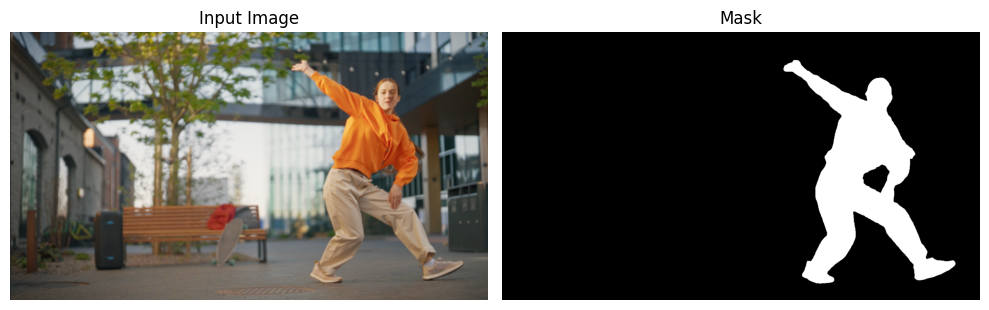

In [4]:
input_image = Image.open(image_path)
mask = Image.open(mask_path).convert('L')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].set_title('Input Image')
axes[0].axis('off')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 2. Process and Save Aligned Mesh

In [5]:

success, output_mesh_path, result = process_and_save_alignment(
    mesh_path=mesh_path,
    mask_path=mask_path,
    image_path=image_path,
    output_dir=output_dir,
    device=device,
    focal_length_json_path=focal_length_json_path
)

if success:
    print(f"Alignment completed successfully! Output: {output_mesh_path}")
else:
    print("Alignment failed!")

[INFO] Starting 3DB mesh alignment pipeline...
[INFO] Processing alignment...
[INFO] Generating MoGe point cloud...


/scratch/cl927/miniconda3/envs/sam3d-objects/lib/python3.11/site-packages/moge/model/v1.py:171: UserWarning: The following deprecated/invalid arguments are ignored: {'output_mask': True, 'split_head': True}
  warnings.warn(f"The following deprecated/invalid arguments are ignored: {deprecated_kwargs}")


[INFO] Loaded focal length from /scratch/cl927/sam-3d-objects/notebook/meshes/human_object/3DB_results/focal_length.json: 1623.0897216796875
[INFO] Cropping mesh with mask...
[INFO] Extracting target points...
[INFO] Aligning mesh to point cloud...
[INFO] Alignment completed - Scale: 0.2183, Target points: 103719
 SUCCESS! Saved aligned mesh to: /scratch/cl927/sam-3d-objects/notebook/meshes/human_object/aligned_meshes/human_aligned.ply
 Processing complete!
Alignment completed successfully! Output: /scratch/cl927/sam-3d-objects/notebook/meshes/human_object/aligned_meshes/human_aligned.ply


## 3. Interactive 3D Visualization


In [7]:
from mesh_alignment import visualize_meshes_interactive

aligned_mesh_path = f"{PATH}/meshes/human_object/aligned_meshes/human_aligned.ply"
dfy_mesh_path = f"{PATH}/meshes/human_object/3Dfy_results/0.glb"

demo, combined_glb_path = visualize_meshes_interactive(
    aligned_mesh_path=aligned_mesh_path,
    dfy_mesh_path=dfy_mesh_path,
    share=True
)

Loading meshes for interactive visualization...
Loaded aligned mesh: 18439 vertices
Loaded 3Dfy mesh: 113498 vertices
Exported combined scene to: /scratch/cl927/sam-3d-objects/notebook/meshes/human_object/aligned_meshes/combined_scene.ply
Exported GLB for Gradio viewer to: /scratch/cl927/sam-3d-objects/notebook/meshes/human_object/aligned_meshes/combined_scene.glb
NOTE: Use PLY for complete data, GLB is for Gradio visualization only
Launching interactive 3D viewer...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://4b39362a78424d8ded.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
